# Convolutional Neural Network


## Importing Libraries


In [854]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Part 1: Data Preprocessing


### Preprocessing the Training set


Found 8000 files belonging to 2 classes.


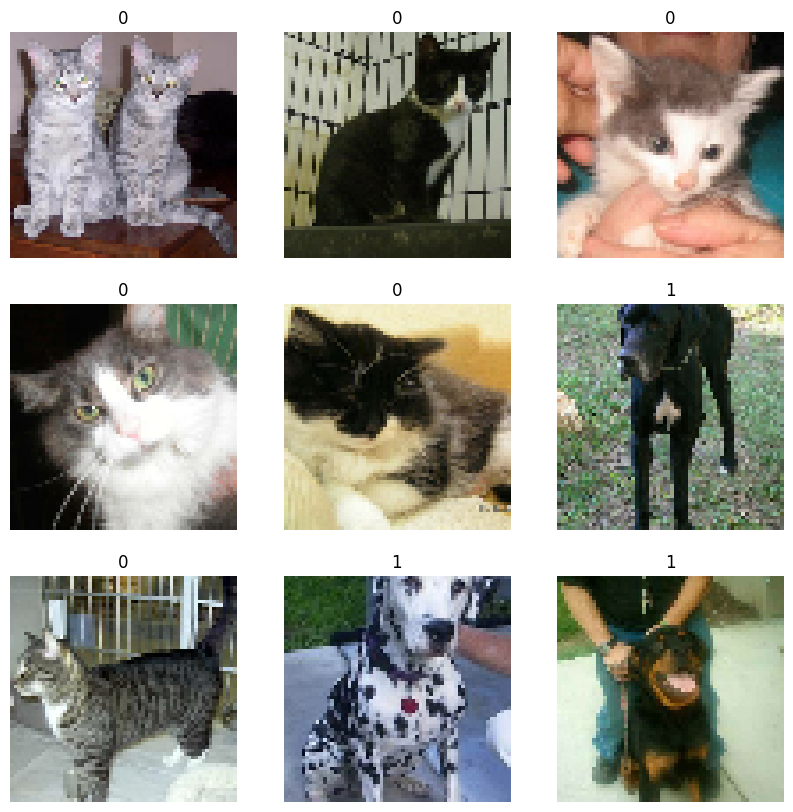

In [855]:
# If we don't apply transformations on images we will get overfitting
# We will apply to thee training set only, we will get huge difference on
# test set and training set accuracies
# Some simple geometrical transformations so as to modify the images to get them augmented
# Image Augmentation
from random import shuffle
from keras.utils import image_dataset_from_directory
from sklearn.model_selection import ShuffleSplit

# Data augmentation and preprocessing
train_ds = image_dataset_from_directory(
    "../datasets/images_dataset/training_set",
    batch_size=32,
    labels="inferred",
    image_size=(64, 64),
    crop_to_aspect_ratio=True,
    shuffle=True,
    seed=1337,
    verbose=True,
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Preprocessing the Test set


Found 2000 files belonging to 2 classes.


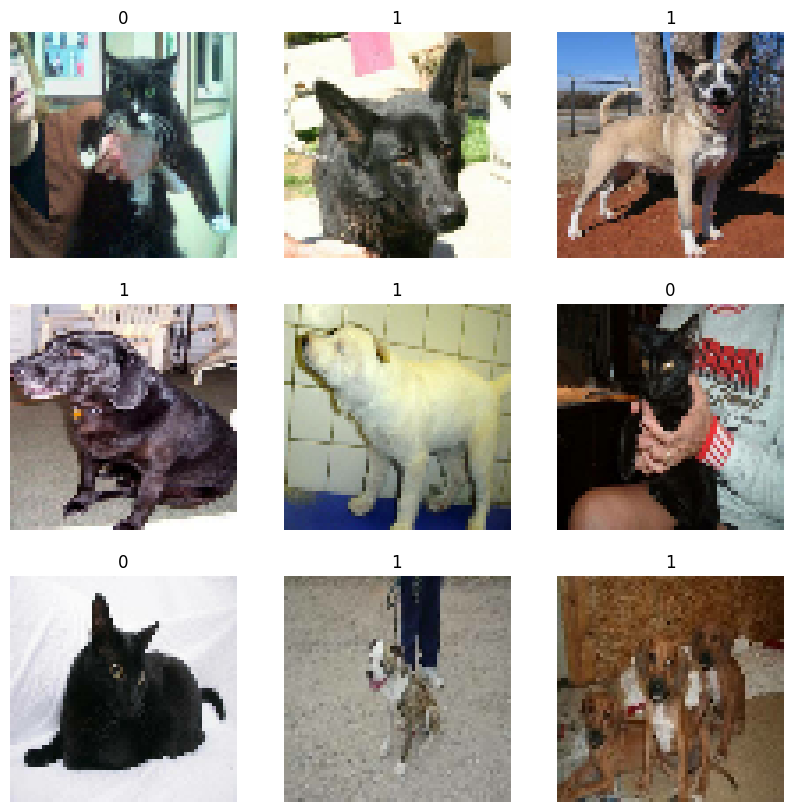

In [856]:
test_ds = image_dataset_from_directory(
    "../datasets/images_dataset/test_set",
    labels="inferred",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=1337,
    verbose=True,
)

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Image Augmentation and Normalizing


In [857]:
from turtle import position
from keras_cv.layers import RandomShear


image_height = 64
max_shear_angle = 0.2
max_shift = max_shear_angle * image_height

layers = [
    tf.keras.layers.RandomZoom(height_factor=(0.8, 1.0), width_factor=(0.8, 1.0)),
    # tf.keras.layers.RandomTranslation(
    #     height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)
    # ),
    tf.keras.layers.RandomContrast(factor=0.2),
    # tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.Rescaling(1.0 / 255),
]


def data_augmentation(images):
    for layer in layers:
        images = layer(images)
    return images

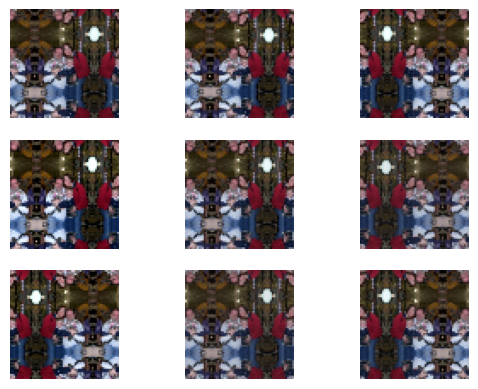

In [858]:
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0] * 255).astype("uint8"))
        plt.axis("off")

In [859]:
train_ds = train_ds.map(
    lambda img, label: (
        data_augmentation(img),
        label,
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

for image, _ in train_ds.take(1):
    print(image)

tf.Tensor(
[[[[0.45714077 0.41394305 0.4159961 ]
   [0.36722454 0.32146955 0.33626097]
   [0.5514726  0.49510935 0.5070438 ]
   ...
   [0.9048897  0.88624215 0.87268263]
   [0.7246655  0.698408   0.7049649 ]
   [0.49113217 0.45804542 0.4673747 ]]

  [[0.54372776 0.49695915 0.4956457 ]
   [0.38604823 0.34357107 0.36460373]
   [0.26520017 0.2492193  0.2739613 ]
   ...
   [0.75663054 0.7588221  0.6692688 ]
   [0.87200034 0.8153811  0.8350123 ]
   [0.58215946 0.5132023  0.521996  ]]

  [[0.33257574 0.3141842  0.33262345]
   [0.2712626  0.26182556 0.29577553]
   [0.3317272  0.32162997 0.35786232]
   ...
   [0.65106755 0.5916108  0.5989161 ]
   [0.7889442  0.73261    0.7339476 ]
   [0.6577224  0.6130303  0.60335606]]

  ...

  [[0.3383604  0.31419367 0.3423878 ]
   [0.29542753 0.27145082 0.2985003 ]
   [0.5227251  0.49913242 0.5189064 ]
   ...
   [0.54559666 0.48397893 0.49428114]
   [0.5086534  0.4684601  0.497683  ]
   [0.6573271  0.60684216 0.6408666 ]]

  [[0.32394636 0.3039157  0.335071

## Part 2: Building the CNN


### Initialising the CNN


In [860]:
cnn = tf.keras.Sequential()  # initializes our ann as a sequence of layers

### Step 1 - Convolution


In [861]:
cnn.add(tf.keras.layers.Input(shape=(64, 64, 3)))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
# filters are the number of feature detectors
# the kernel size is the size of the feature detector
# input shape is the size and color channels added only on the first layer

### Step 2 - Pooling


In [862]:
cnn.add(
    tf.keras.layers.MaxPool2D(
        pool_size=2,
        strides=2,
    )
)

### Adding a Second Convolutional Layer


In [863]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
cnn.add(
    tf.keras.layers.MaxPool2D(
        pool_size=2,
        strides=2,
    )
)

### Step 3 - Flattening


In [864]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection


In [865]:
cnn.add(tf.keras.layers.Dense(units=128, activation="relu"))

### Step 5 - Output Layer


In [866]:
cnn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [867]:
cnn.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,217 (3.10 MB)

 Trainable params: 813,217 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

## Part 3: Training the CNN


### Compiling the CNN


In [868]:
cnn.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)  # for non-binary the loss is categorical_crossentropy

### Training the ANN on the Training set and Evalutaing it on the Test set


In [870]:
cnn.fit(train_ds, validation_data=test_ds, epochs=30)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9591 - loss: 0.1121 - val_accuracy: 0.6060 - val_loss: 251.9726
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9589 - loss: 0.1088 - val_accuracy: 0.6125 - val_loss: 290.8863
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9587 - loss: 0.0989 - val_accuracy: 0.5905 - val_loss: 283.1242
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9662 - loss: 0.0933 - val_accuracy: 0.6150 - val_loss: 311.6438
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9679 - loss: 0.0903 - val_accuracy: 0.5985 - val_loss: 314.3633
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9675 - loss: 0.0805 - val_accuracy: 0.5940 - val_loss: 348.6557
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9716 - loss: 0.0700 - val_accuracy: 0.5940 - val_loss: 352.2222
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9774 - loss: 0.0

## Part 4: Making a Single Prediction
